In [1]:
import torch
import torch.nn as nn
import os
import math

In [2]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        self.feature_dim = feature_dim
        hidden_dim = 2 * feature_dim
        self.Linear1 = nn.Linear(self.D, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.ReLU = nn.Sigmoid()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        hidden_layer = self.Linear1(X)
        ReLU_layer = self.ReLU(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
#         hyp = torch.log(torch.ones(self.D + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
#         hyp = torch.cat([hyp, torch.log(torch.ones(self.D + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        hyp = torch.nn.Parameter(hyp, requires_grad=True)
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        
        psi1 = rho * self.kernel(X_H, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)
        pred_u = torch.matmul(psi, alpha)
        
        
        
        NLML = 0.5 * torch.matmul(y.T, alpha) + \
               torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
        return NLML[0, 0],pred_u
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H
        L = self.L
        X_star = self.feature_get(X_star_raw)
#         X_star = X_star_raw

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))

In [3]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
%matplotlib inline  
np.random.seed(1234)

In [4]:
def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [5]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

In [6]:
# Training data    
X_L = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
y_L = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1,1)

X_H = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
y_H = np.loadtxt('./dataset/y_train_high.txt').reshape(-1,1)

# Test data
X_star = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
y_star = np.loadtxt('./dataset/y_test_high.txt').reshape(-1,1)

#  #  Normalize Input Data
# if Normalize_input_data == 1:
#     X = np.vstack((X_L,X_H))
# #     X=X.T
#     X_m = np.mean(X, axis = 0)
#     X_s = np.std(X, axis = 0)   
#     X_L = Normalize(X_L, X_m, X_s)
#     X_H = Normalize(X_H, X_m, X_s)
#     lb = Normalize(lb, X_m, X_s)
#     ub = Normalize(ub, X_m, X_s)
#     X_star = Normalize(X_star, X_m, X_s)

# #  Normalize Output Data
# if Normalize_output_data == 1:
#     y = np.vstack((y_L,y_H))
# #     y=y.T
#     y_m = np.mean(y, axis = 0)
#     y_s = np.std(y, axis = 0)   
#     y_L = Normalize(y_L, y_m, y_s)
#     y_H = Normalize(y_H, y_m, y_s)
#     y_star = Normalize(y_star, y_m, y_s)
    

# # Plot the training data
# plt.figure(facecolor='w')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=16)
# plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
# plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
# plt.title("Training data")
# ax = plt.gca()
# # ax.set_xlim([lb[0], ub[0]])
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')

In [7]:
X_L=X_L.reshape(-1,32)
X_H=X_H.reshape(-1,32)
y_L=y_L.reshape(-1,1)
y_H=y_H.reshape(-1,1)
feature_dim = 48

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()

In [8]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim)

Total number of parameters: 101


In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn=torch.nn.MSELoss()
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [20]:
state = {'model':model.state_dict(), 'optimizer':optimizer.state_dict()}

一、

1. 先建立一个字典，保存三个参数：

state = {‘net':model.state_dict(), 'optimizer':optimizer.state_dict(), 'epoch':epoch}

2.调用torch.save():

torch.save(state, dir)

其中dir表示保存文件的绝对路径+保存文件名，如'/home/qinying/Desktop/modelpara.pth'

二、

当你想恢复某一阶段的训练（或者进行测试）时，那么就可以读取之前保存的网络模型参数等。

checkpoint = torch.load(dir)

model.load_state_dict(checkpoint['net'])

optimizer.load_state_dict(checkpoint['optimizer'])

start_epoch = checkpoint['epoch'] + 1

In [30]:
epoches = 1500

for e in range(epoches):
    optimizer.zero_grad()
    loss1,pred=model()
    loss2 = loss_fn(pred,y_H)
#     if loss<0:
#         break
    if (e)%5==0:
        print(f'epoch: {e}  loss1: {loss1.item()}  loss2: {loss2.item()}')
#         print(f'epoch: {e}  loss2: {loss2.item()}')
#     loss1.backward(retain_graph=True)
    loss2.backward()
    optimizer.step()

epoch: 0  loss1: 264.650634765625  loss2: 0.0022125786636024714
epoch: 5  loss1: 312.03466796875  loss2: 0.0015750753227621317
epoch: 10  loss1: 381.500732421875  loss2: 0.0009617871837690473
epoch: 15  loss1: 485.1207275390625  loss2: 0.0007954401080496609
epoch: 20  loss1: 576.7083740234375  loss2: 0.0006104641361162066
epoch: 25  loss1: 661.25634765625  loss2: 0.0005018896190449595
epoch: 30  loss1: 749.1243896484375  loss2: 0.0004166112339589745
epoch: 35  loss1: 840.2740478515625  loss2: 0.0003549404500517994
epoch: 40  loss1: 934.0611572265625  loss2: 0.00030783037072978914
epoch: 45  loss1: 1031.044677734375  loss2: 0.0002700321492739022
epoch: 50  loss1: 1129.260986328125  loss2: 0.00024054088862612844
epoch: 55  loss1: 1220.53662109375  loss2: 0.00021520612062886357
epoch: 60  loss1: 1309.6845703125  loss2: 0.00019424462516326457
epoch: 65  loss1: 1400.48681640625  loss2: 0.00017698010196909308
epoch: 70  loss1: 1487.45947265625  loss2: 0.00016084607341326773
epoch: 75  loss1:

epoch: 630  loss1: 5071.341796875  loss2: 2.8478070817072876e-06
epoch: 635  loss1: 5081.7265625  loss2: 3.557796389941359e-06
epoch: 640  loss1: 5092.1630859375  loss2: 4.0160707612812985e-06
epoch: 645  loss1: 5101.05712890625  loss2: 2.9482873742381344e-06
epoch: 650  loss1: 5106.572265625  loss2: 4.958080808137311e-06
epoch: 655  loss1: 5112.2255859375  loss2: 3.4472905099391937e-06
epoch: 660  loss1: 5124.42578125  loss2: 2.4535111151635647e-06
epoch: 665  loss1: 5127.3662109375  loss2: 2.354494426981546e-06
epoch: 670  loss1: 5131.1943359375  loss2: 2.125314040313242e-06
epoch: 675  loss1: 5139.62060546875  loss2: 2.8459694476623554e-06
epoch: 680  loss1: 5148.384765625  loss2: 2.506388682377292e-06
epoch: 685  loss1: 5153.74169921875  loss2: 3.423486305109691e-06
epoch: 690  loss1: 5161.5751953125  loss2: 2.5282720343966503e-06
epoch: 695  loss1: 5167.7783203125  loss2: 1.7997670056502102e-06
epoch: 700  loss1: 5173.0009765625  loss2: 2.348069301660871e-06
epoch: 705  loss1: 517

epoch: 1260  loss1: 5171.341796875  loss2: 5.579786375164986e-07
epoch: 1265  loss1: 5173.3017578125  loss2: 1.1757781521737343e-06
epoch: 1270  loss1: 5172.05224609375  loss2: 9.365612640976906e-07
epoch: 1275  loss1: 5171.48046875  loss2: 4.562205617730797e-07
epoch: 1280  loss1: 5172.5771484375  loss2: 7.808890245541988e-07
epoch: 1285  loss1: 5173.0126953125  loss2: 1.554970594952465e-06
epoch: 1290  loss1: 5171.8935546875  loss2: 4.6029785494283715e-07
epoch: 1295  loss1: 5172.3798828125  loss2: 6.995174999246956e-07
epoch: 1300  loss1: 5172.6513671875  loss2: 2.067951925255329e-07
epoch: 1305  loss1: 5172.462890625  loss2: 8.586516742070671e-07
epoch: 1310  loss1: 5174.95068359375  loss2: 6.964851309021469e-07
epoch: 1315  loss1: 5176.30517578125  loss2: 4.553751580260723e-07
epoch: 1320  loss1: 5178.9091796875  loss2: 1.4118877516011707e-06
epoch: 1325  loss1: 5170.2265625  loss2: 4.575759646741062e-07
epoch: 1330  loss1: 5168.0185546875  loss2: 9.781936114450218e-07
epoch: 1335

In [31]:
torch.save(state,'19.modelParams.pth')

In [32]:
X_star=torch.from_numpy(np.array(X_star).reshape(-1,32)).float()

In [33]:
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [40]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy()-1, y_var.detach().numpy()

Relative L2 error u: 8.614656e-02
r2 socre: -0.32837866722957276
[[31.1779]
 [29.1824]
 [26.4095]
 [26.9644]
 [30.09  ]
 [26.837 ]
 [25.28  ]
 [31.4606]
 [30.1555]] [[29.25592 ]
 [29.47992 ]
 [26.335434]
 [29.355988]
 [24.285019]
 [25.397781]
 [25.109802]
 [28.530975]
 [29.098145]]
[0.04658055 0.05874348 0.16904926 0.06264925 0.19120836 0.1974771
 0.20919406 0.13058996 0.08647954]


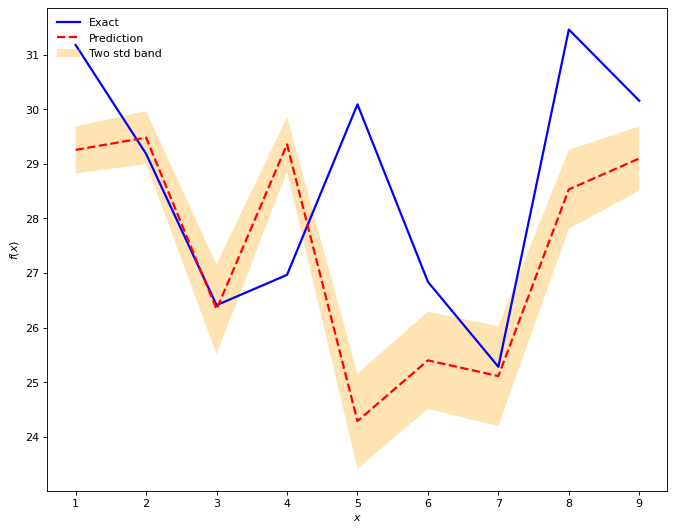

In [42]:
file_write_obj = open("19.Adam-without-norm-500-epoch-feature48-lr1e-4-3.3-twoloss.txt", 'w')
# for var in mylist:
#     file_write_obj.writelines(var)
#     file_write_obj.write('\n')


# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

file_write_obj.write('Relative L2 error')
file_write_obj.write(str(error))
file_write_obj.write('\n')

index=[1,2,3,4,5,6,7,8,9]
y_pred=np.array(y_pred)
y_star=np.array(y_star)

print("r2 socre:",r2_score(y_star,y_pred))

file_write_obj.write('r2 socre')
file_write_obj.writelines(str(r2_score(y_star,y_pred)))
file_write_obj.write('\n')

print(y_star, y_pred)
file_write_obj.write('Exact')
file_write_obj.write(str(y_star))
file_write_obj.write('\n')

file_write_obj.write('Predict')
file_write_obj.write(str(y_pred))
file_write_obj.write('\n')

y_var_new=np.abs(np.diag(y_var))
print(y_var_new)

file_write_obj.write('std')
file_write_obj.write(str(y_var_new))
file_write_obj.write('\n')

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig("19.Adam-without-norm-1500-epoch-feature48-lr1e-4-newmethod-twoloss.png")
file_write_obj.close()


In [ ]:
y_pred2, y_var2 = model.predict(X_H)
y_pred2, y_var2 = y_pred2.detach().numpy(), y_var2.detach().numpy()

In [ ]:

# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))


index=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
y_pred2=np.array(y_pred2)
y_star2=np.array(y_H)

print("r2 socre:",r2_score(y_star2,y_pred2))

print(y_star2, y_pred2)

y_var_new=abs(y_var2.mean(axis=1))*9
print(y_var_new)


# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star2, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred2, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred2 - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred2 + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')


